In [31]:
from __future__ import annotations

from pathlib import Path

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

# Paths
REPO_ROOT = Path('..').resolve()
DATA_PATH = REPO_ROOT / 'data' / '02-preprocessed' / 'cybersecurity_attacks_v1_2025-12-29' / 'cleaned.csv'
VIZ_CONFIG_PATH = REPO_ROOT / 'config' / 'visualization.json'

DATA_PATH, VIZ_CONFIG_PATH

(WindowsPath('C:/repos/ml-cybersecurity_attacks/data/02-preprocessed/cybersecurity_attacks_v1_2025-12-29/cleaned.csv'),
 WindowsPath('C:/repos/ml-cybersecurity_attacks/config/visualization.json'))

In [32]:
# Load shared visualization config (color palette)
def load_color_palette(config_path: Path) -> list[str]:
    if not config_path.exists():
        return sns.color_palette('tab10').as_hex()
    cfg = json.loads(config_path.read_text(encoding='utf-8'))
    palette = cfg.get('visualization', {}).get('color_palette', None)
    if not palette:
        return sns.color_palette('tab10').as_hex()
    return palette

color_palette = load_color_palette(VIZ_CONFIG_PATH)
sns.set_theme(style='whitegrid')
color_palette

['#c6d4e1',
 '#9bbcd4',
 '#6fa3c7',
 '#4a8ab8',
 '#2f6fa1',
 '#1f4f75',
 '#d3d3d3',
 '#a9a9a9',
 '#696969']

In [33]:
# Load cleaned dataset
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Could not find cleaned dataset at: {DATA_PATH}')

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(40000, 26)


,row_id,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,row_000000,2023-05-30 06:33:58+00:00,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,row_000001,2020-08-26 07:08:30+00:00,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,row_000002,2022-11-13 08:23:25+00:00,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,row_000003,2023-07-02 10:38:46+00:00,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,NaN,15.79,Alert Triggered,Malware,Known Pattern B,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,row_000004,2023-07-16 13:11:07+00:00,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,NaN,0.52,Alert Triggered,DDoS,Known Pattern B,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [34]:
# Helper: robust column detection (handles different casing/spacing)
def _norm_col(name: str) -> str:
    return ''.join(ch for ch in name.lower() if ch.isalnum())

def find_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    norm_map = {_norm_col(c): c for c in df.columns}
    for cand in candidates:
        key = _norm_col(cand)
        if key in norm_map:
            return norm_map[key]
    return None

# Expected columns per Kaggle README (but keep flexible)
col_timestamp = find_col(df, ['Timestamp', 'Time', 'Datetime', 'DateTime', 'Event Time', 'EventTime'])
col_attack_type = find_col(df, ['Attack Type', 'AttackType', 'attack_type'])
col_browser = find_col(df, ['Browser', 'User Agent', 'UserAgent', 'user_agent'])
col_device = find_col(df, ['Device Information', 'Device', 'DeviceInfo', 'device'])
col_os = find_col(df, ['OS', 'Operating System', 'OperatingSystem', 'os'])
col_traffic_type = find_col(df, ['Traffic Type', 'TrafficType', 'traffic_type'])
col_protocol = find_col(df, ['Protocol', 'protocol'])
col_log_source = find_col(df, ['Log Source', 'LogSource', 'log_source'])
col_action_taken = find_col(df, ['Action Taken', 'ActionTaken', 'action_taken'])
col_ids_ips_alerts = find_col(df, ['IDS/IPS Alerts', 'IDS IPS Alerts', 'IDS Alerts', 'IPS Alerts', 'ids_ips_alerts'])
col_alerts_warnings = find_col(df, ['Alerts/Warnings', 'Alerts Warnings', 'Alerts', 'Warnings', 'alerts_warnings'])
col_malware_indicators = find_col(df, ['Malware Indicators', 'MalwareIndicators', 'malware_indicators'])
col_geo = find_col(df, ['Geo-location Data', 'Geo Location Data', 'Geo-location', 'Geolocation', 'GeoLocation', 'geo_location', 'Country', 'country'])

found = {
    'timestamp': col_timestamp,
    'attack_type': col_attack_type,
    'browser': col_browser,
    'device': col_device,
    'os': col_os,
    'traffic_type': col_traffic_type,
    'protocol': col_protocol,
    'log_source': col_log_source,
    'action_taken': col_action_taken,
    'ids_ips_alerts': col_ids_ips_alerts,
    'alerts_warnings': col_alerts_warnings,
    'malware_indicators': col_malware_indicators,
    'geo': col_geo,
}
found

{'timestamp': 'Timestamp',
 'attack_type': 'Attack Type',
 'browser': None,
 'device': 'Device Information',
 'os': None,
 'traffic_type': 'Traffic Type',
 'protocol': 'Protocol',
 'log_source': 'Log Source',
 'action_taken': 'Action Taken',
 'ids_ips_alerts': 'IDS/IPS Alerts',
 'alerts_warnings': 'Alerts/Warnings',
 'malware_indicators': 'Malware Indicators',
 'geo': 'Geo-location Data'}

In [35]:
# Derive Browser / OS if not present as dedicated columns
col_user_info = find_col(df, ['User Information', 'UserInformation', 'user_information', 'User Agent', 'UserAgent', 'user_agent'])

def extract_browser_from_text(series: pd.Series) -> pd.Series:
    s = series.astype('string').fillna('')
    s_lower = s.str.lower()
    browser = pd.Series(np.full(len(s_lower), 'Other', dtype=object), index=s_lower.index)
    browser[s_lower.str.contains('edg|edge')] = 'Edge'
    browser[s_lower.str.contains('opr|opera')] = 'Opera'
    browser[s_lower.str.contains('firefox')] = 'Firefox'
    # Safari often appears with Chrome on iOS/macOS; check Chrome before Safari
    browser[s_lower.str.contains('chrome|crios')] = 'Chrome'
    browser[s_lower.str.contains('safari') & ~s_lower.str.contains('chrome|crios|chromium|edg|edge|opr|opera')] = 'Safari'
    browser[s_lower.str.contains('msie|trident')] = 'Internet Explorer'
    browser[browser.isna() | (browser.astype('string') == '')] = 'Unknown'
    return browser

def extract_os_from_text(series: pd.Series) -> pd.Series:
    s = series.astype('string').fillna('')
    s_lower = s.str.lower()
    os_ = pd.Series(np.full(len(s_lower), 'Other', dtype=object), index=s_lower.index)
    os_[s_lower.str.contains('windows nt|win64|win32|windows')] = 'Windows'
    os_[s_lower.str.contains('mac os x|macintosh')] = 'macOS'
    os_[s_lower.str.contains('android')] = 'Android'
    os_[s_lower.str.contains('iphone|ipad|ios')] = 'iOS'
    os_[s_lower.str.contains('linux')] = 'Linux'
    os_[os_.isna() | (os_.astype('string') == '')] = 'Unknown'
    return os_

if col_browser is None and col_user_info is not None:
    df['browser'] = extract_browser_from_text(df[col_user_info])
    col_browser = 'browser'

if col_os is None and col_user_info is not None:
    df['os'] = extract_os_from_text(df[col_user_info])
    col_os = 'os'

# Reprint detected/derived columns summary
found = {
    'timestamp': col_timestamp,
    'attack_type': col_attack_type,
    'browser': col_browser,
    'device': col_device,
    'os': col_os,
    'traffic_type': col_traffic_type,
    'protocol': col_protocol,
    'log_source': col_log_source,
    'action_taken': col_action_taken,
    'ids_ips_alerts': col_ids_ips_alerts,
    'alerts_warnings': col_alerts_warnings,
    'malware_indicators': col_malware_indicators,
    'geo': col_geo,
    'user_info': col_user_info,
}
found

{'timestamp': 'Timestamp',
 'attack_type': 'Attack Type',
 'browser': 'browser',
 'device': 'Device Information',
 'os': 'os',
 'traffic_type': 'Traffic Type',
 'protocol': 'Protocol',
 'log_source': 'Log Source',
 'action_taken': 'Action Taken',
 'ids_ips_alerts': 'IDS/IPS Alerts',
 'alerts_warnings': 'Alerts/Warnings',
 'malware_indicators': 'Malware Indicators',
 'geo': 'Geo-location Data',
 'user_info': 'User Information'}

In [36]:
# Create a combined Device/OS column (regex-based)
import re

devices = [
    r'Windows',
    r'Linux',
    r'Android',
    r'iPad',
    r'iPod',
    r'iPhone',
    r'Macintosh',
]

_device_patterns = [re.compile(pat, flags=re.IGNORECASE) for pat in devices]

def device_os_finder(user_agent: str) -> str:
    if user_agent is None:
        return 'Unknown'
    text = str(user_agent)
    if not text:
        return 'Unknown'
    for pat in _device_patterns:
        match_device = pat.search(text)
        if match_device:
            return match_device.group()
    return 'Unknown'

# Prefer 'Device Information' when present; fallback to 'User Information' (user-agent-like)
device_os_source_col = col_device if col_device is not None else col_user_info
if device_os_source_col is None:
    raise KeyError("Could not find a source column for Device/OS. Expected 'Device Information' or 'User Information'.")

df['Device/OS'] = df[device_os_source_col].apply(device_os_finder)
df[['Device/OS']].head(10)

,Device/OS
0,Windows
1,Windows
2,Windows
3,Macintosh
4,Windows
5,Linux
6,Linux
7,Macintosh
8,Macintosh
9,Windows


In [37]:
# Create a Browser column from Device Information (split on '/')
if col_device is None:
    raise KeyError("Could not auto-detect 'Device Information' column.")

df['Browser'] = df[col_device].astype('string').str.split('/').str[0]
df['Browser']

0        Mozilla
1        Mozilla
2        Mozilla
3        Mozilla
4        Mozilla
          ...   
39995    Mozilla
39996    Mozilla
39997    Mozilla
39998    Mozilla
39999    Mozilla
Name: Browser, Length: 40000, dtype: object

In [38]:
# Basic dataset summary
df.describe(include='all').T.head(25)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,40000,40000,row_000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Timestamp,40000,39997,2022-04-17 20:05:34+00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source IP Address,40000,40000,103.216.15.12,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination IP Address,40000,40000,84.9.164.252,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source Port,40000.0,NaN,NaN,NaN,32970.35645,18560.425604,1027.0,16850.75,32856.0,48928.25,65530.0
Destination Port,40000.0,NaN,NaN,NaN,33150.86865,18574.668842,1024.0,17094.75,33004.5,49287.0,65535.0
Protocol,40000,3,ICMP,13429,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Packet Length,40000.0,NaN,NaN,NaN,781.452725,416.044192,64.0,420.0,782.0,1143.0,1500.0
Packet Type,40000,2,Control,20237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Traffic Type,40000,3,DNS,13376,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Create time columns
if col_timestamp is None:
    raise KeyError(
        'Could not auto-detect a timestamp column. '
        'Update col_timestamp candidates or rename your datetime column to Timestamp.'
    )

df[col_timestamp] = pd.to_datetime(df[col_timestamp], errors='coerce', utc=False)

# Drop rows where timestamp failed to parse (optional, but keeps plots clean)
before = len(df)
df = df.dropna(subset=[col_timestamp]).copy()
print(f'Dropped {before - len(df):,} rows with invalid timestamp')

df['year'] = df[col_timestamp].dt.year
df['month'] = df[col_timestamp].dt.month
df['dayofweek'] = df[col_timestamp].dt.dayofweek
df['day'] = df[col_timestamp].dt.day
df['hour'] = df[col_timestamp].dt.hour
df['minute'] = df[col_timestamp].dt.minute
df['second'] = df[col_timestamp].dt.second

df[['year','month','dayofweek','day','hour','minute','second']].head()

Dropped 0 rows with invalid timestamp


,year,month,dayofweek,day,hour,minute,second
0,2023,5,1,30,6,33,58
1,2020,8,2,26,7,8,30
2,2022,11,6,13,8,23,25
3,2023,7,6,2,10,38,46
4,2023,7,6,16,13,11,7


## Charts
All charts below use `color_palette` from `config/visualization.json`.

In [40]:
def _value_counts_df(series: pd.Series, name: str) -> pd.DataFrame:
    out = (
        series.astype('string')
        .fillna('Unknown')
        .value_counts(dropna=False)
        .rename_axis(name)
        .reset_index(name='count')
    )
    return out

def _barplot_counts(data: pd.DataFrame, x: str, y: str, title: str, rotation: int = 0):
    # Seaborn v0.14+ prefers palette paired with hue; set hue=x and disable legend.
    plt.figure(figsize=(12, 5))
    n = int(data[x].nunique(dropna=False))
    palette = [color_palette[i % len(color_palette)] for i in range(n)]
    ax = sns.barplot(data=data, x=x, y=y, hue=x, palette=palette, legend=False)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if rotation:
        plt.xticks(rotation=rotation, ha='right')
    plt.tight_layout()
    return ax

### Number of Attack Types by Year

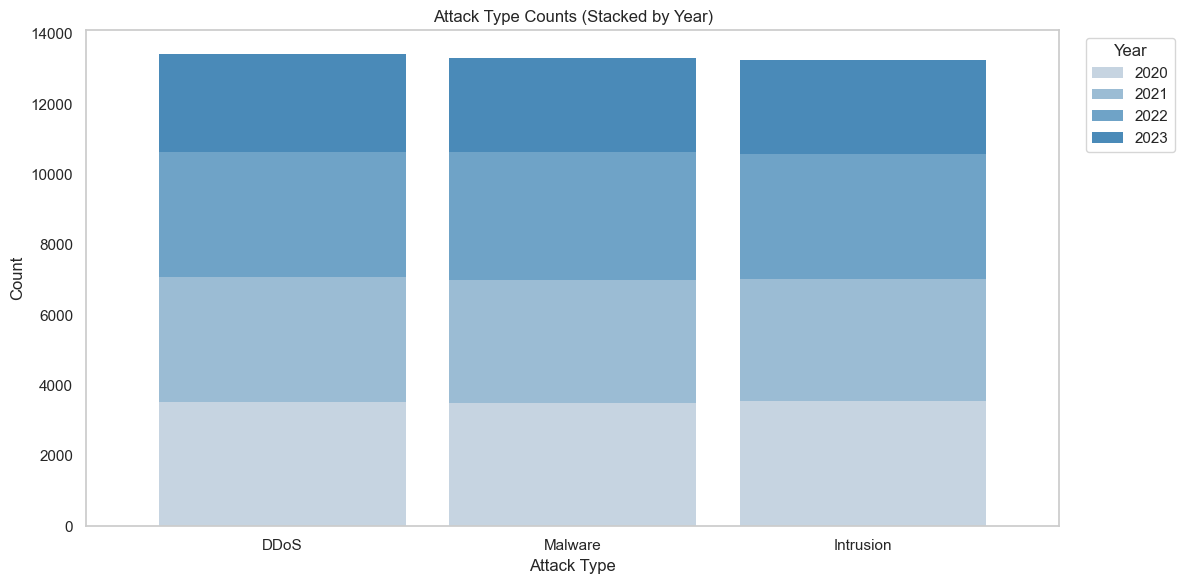

In [41]:
if col_attack_type is None:
    raise KeyError('Could not auto-detect Attack Type column.')

# Build counts by year + attack type
attack_by_year = (
    df.assign(attack_type=df[col_attack_type].astype('string').fillna('Unknown'))
      .groupby(['year', 'attack_type'], dropna=False)
      .size()
      .reset_index(name='count')
)

# Pivot so x-axis is Attack Type and stacks represent Year
attack_by_type_year_pivot = (
    attack_by_year.pivot(index='attack_type', columns='year', values='count')
      .fillna(0)
    )

# Order years ascending, keep attack types sorted by total count (desc)
years_sorted = sorted(attack_by_type_year_pivot.columns.tolist())
attack_by_type_year_pivot = attack_by_type_year_pivot[years_sorted]
attack_by_type_year_pivot = attack_by_type_year_pivot.loc[
    attack_by_type_year_pivot.sum(axis=1).sort_values(ascending=False).index
] .copy()

# Use palette colors (repeat if there are more years than colors)
colors = [color_palette[i % len(color_palette)] for i in range(len(years_sorted))]

ax = attack_by_type_year_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Attack Type Counts (Stacked by Year)')
ax.set_xlabel('Attack Type')
ax.set_ylabel('Count')

# Styling tweaks
ax.grid(False)
plt.xticks(rotation=0)
plt.legend(title='Year', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Attack Types by Month

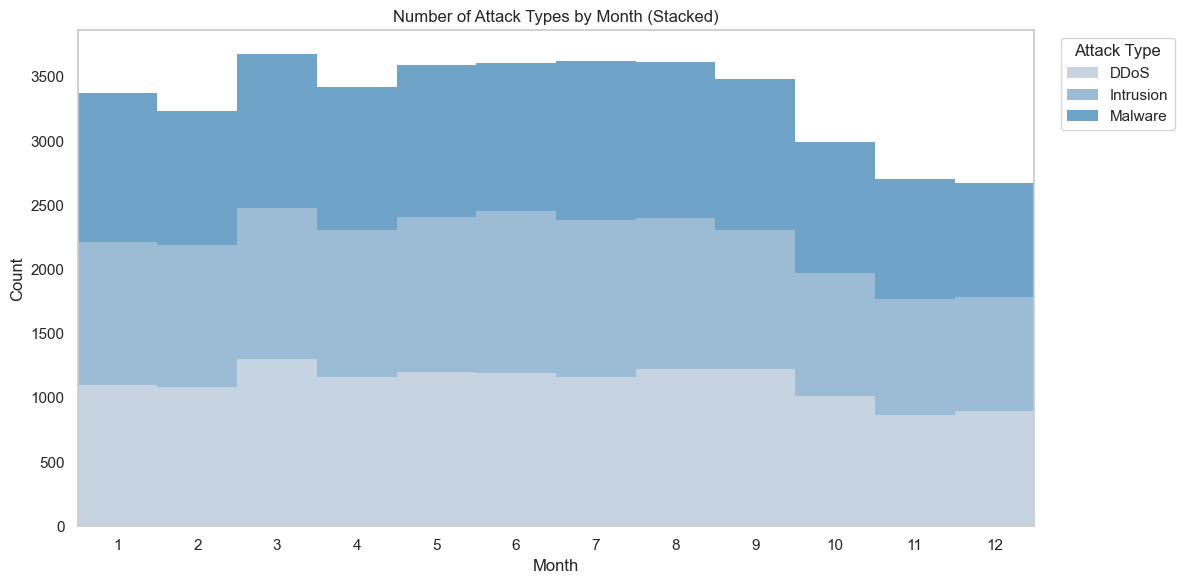

In [42]:
if col_attack_type is None:
    raise KeyError('Could not auto-detect Attack Type column.')

attack_by_month = (
    df.assign(attack_type=df[col_attack_type].astype('string').fillna('Unknown'))
      .groupby(['month', 'attack_type'], dropna=False)
      .size()
      .reset_index(name='count')
)

# Stacked bar by month (no gaps between months)
attack_by_month_pivot = (
    attack_by_month.pivot(index='month', columns='attack_type', values='count')
      .fillna(0)
      .sort_index()
    )

# Ensure months show in natural order (1..12)
months_sorted = sorted(attack_by_month_pivot.index.tolist())
attack_by_month_pivot = attack_by_month_pivot.loc[months_sorted]

attack_types = list(attack_by_month_pivot.columns)
colors = [color_palette[i % len(color_palette)] for i in range(len(attack_types))]

ax = attack_by_month_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors,
    width=1.0,
    edgecolor='none',
)
ax.set_title('Number of Attack Types by Month (Stacked)')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

# Remove gridlines + remove horizontal padding so months touch
ax.grid(False)
ax.margins(x=0)
ax.set_xlim(-0.5, len(months_sorted) - 0.5)

plt.xticks(rotation=0)
plt.legend(title='Attack Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Total Count by Browser

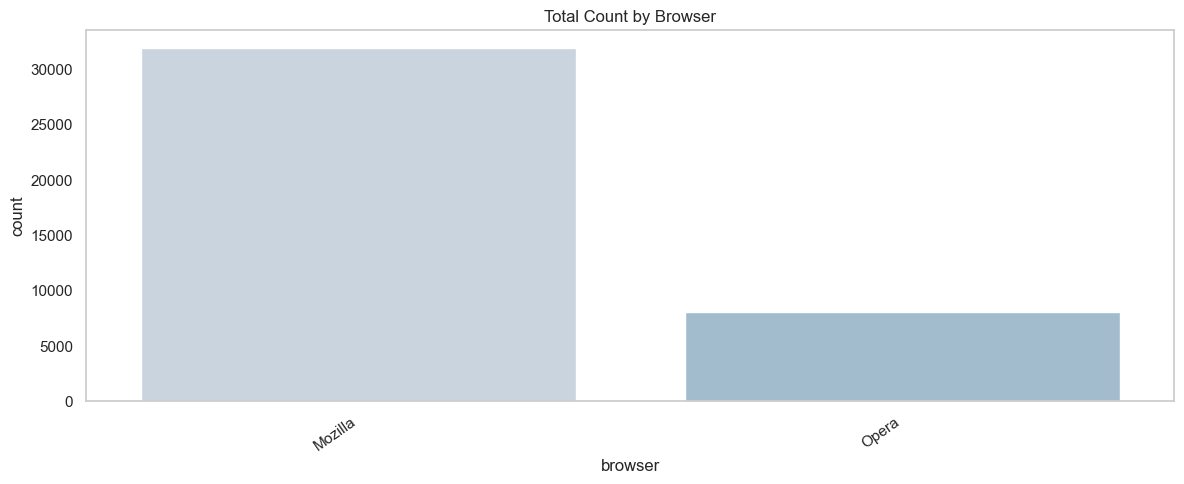

In [43]:
# Total Count by Browser (prefer the derived df['Browser'] column if present)
browser_col = 'Browser' if 'Browser' in df.columns else col_browser
if browser_col is None:
    raise KeyError("Could not find a browser column. Expected 'Browser' or an auto-detected Browser/User-Agent column.")

browser_counts = _value_counts_df(df[browser_col], 'browser')

ax = _barplot_counts(browser_counts, x='browser', y='count', title='Total Count by Browser', rotation=35)
ax.grid(False)
plt.show()

### Device/OS Types
If your dataset has both a device field and an OS field, this chart shows combined **Device | OS** categories.

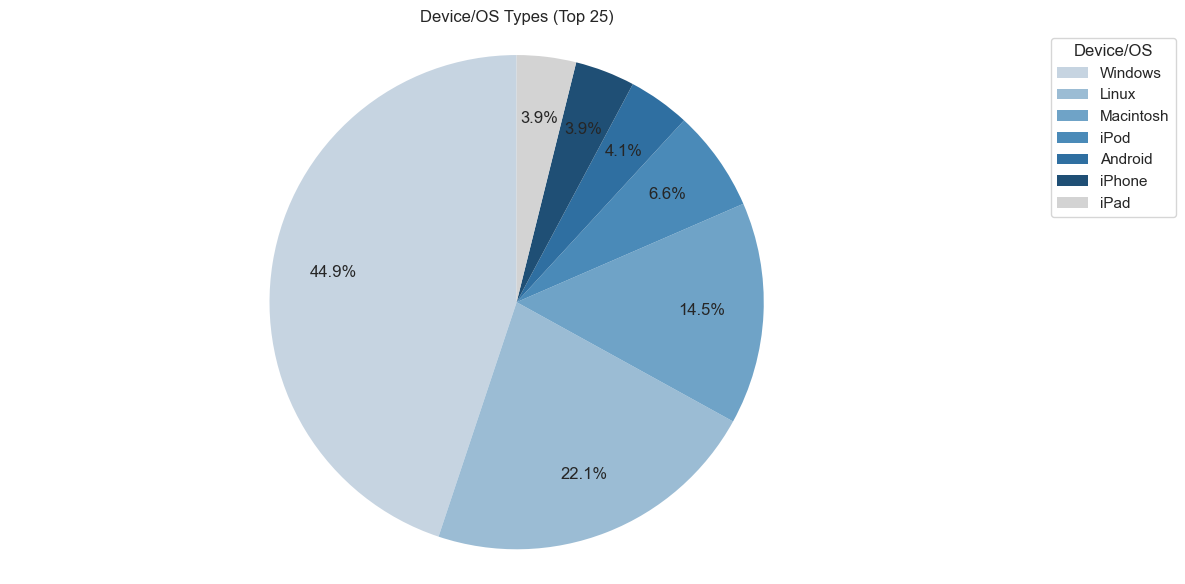

In [44]:
# Prefer the derived regex-based Device/OS column if present; otherwise fall back to Device | OS combo
device_os_col = 'Device/OS' if 'Device/OS' in df.columns else None

if device_os_col is None and col_device is None and col_os is None:
    raise KeyError('Could not auto-detect Device/OS column or (Device and/or OS columns).')

if device_os_col is not None:
    device_os = df[device_os_col].astype('string').fillna('Unknown').rename('device_os')
else:
    device_series = df[col_device].astype('string').fillna('Unknown') if col_device else pd.Series(['Unknown'] * len(df))
    os_series = df[col_os].astype('string').fillna('Unknown') if col_os else pd.Series(['Unknown'] * len(df))
    device_os = (device_series + ' | ' + os_series).rename('device_os')

device_os_counts = _value_counts_df(device_os, 'device_os').head(25)

labels = device_os_counts['device_os'].astype(str).tolist()
sizes = device_os_counts['count'].astype(float).tolist()
colors = [color_palette[i % len(color_palette)] for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(12, 6))
wedges, *_ = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    labels=None,
    autopct='%1.1f%%',
    pctdistance=0.75,
    wedgeprops={'edgecolor': 'none'},
 )
ax.set_title('Device/OS Types (Top 25)')
ax.axis('equal')  # keep as a circle
ax.legend(wedges, labels, title='Device/OS', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Traffic Type by Browser

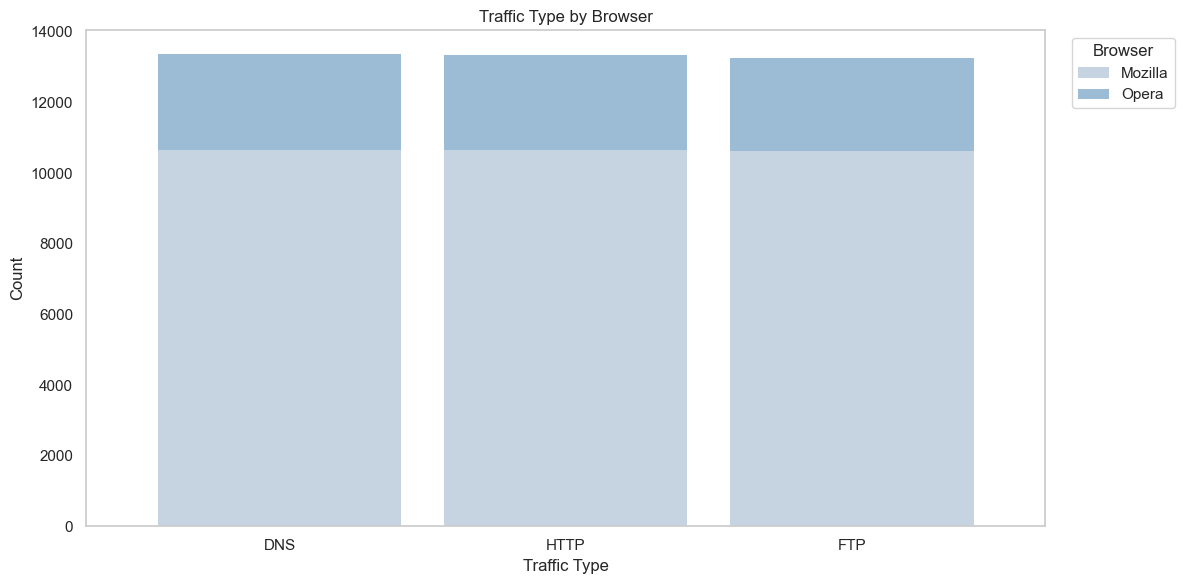

In [45]:
# Traffic Type by Browser (stacked; x-axis = Traffic Type; prefer the derived df['Browser'] column if present)
if col_traffic_type is None:
    raise KeyError('Could not auto-detect Traffic Type column.')

browser_col = 'Browser' if 'Browser' in df.columns else col_browser
if browser_col is None:
    raise KeyError("Could not find a browser column. Expected 'Browser' or an auto-detected Browser/User-Agent column.")

traffic_by_browser = (
    df.assign(
        traffic_type=df[col_traffic_type].astype('string').fillna('Unknown'),
        browser=df[browser_col].astype('string').fillna('Unknown'),
    )
      .groupby(['traffic_type', 'browser'], dropna=False)
      .size()
      .reset_index(name='count')
)

traffic_by_browser_pivot = (
    traffic_by_browser.pivot(index='traffic_type', columns='browser', values='count')
      .fillna(0)
    )

# Keep traffic types ordered by total count (desc)
traffic_by_browser_pivot = traffic_by_browser_pivot.loc[
    traffic_by_browser_pivot.sum(axis=1).sort_values(ascending=False).index
]

browsers = traffic_by_browser_pivot.columns.tolist()
colors = [color_palette[i % len(color_palette)] for i in range(len(browsers))]

ax = traffic_by_browser_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Traffic Type by Browser')
ax.set_xlabel('Traffic Type')
ax.set_ylabel('Count')

ax.grid(False)
plt.xticks(rotation=0)
plt.legend(title='Browser', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Attack Type by Protocol

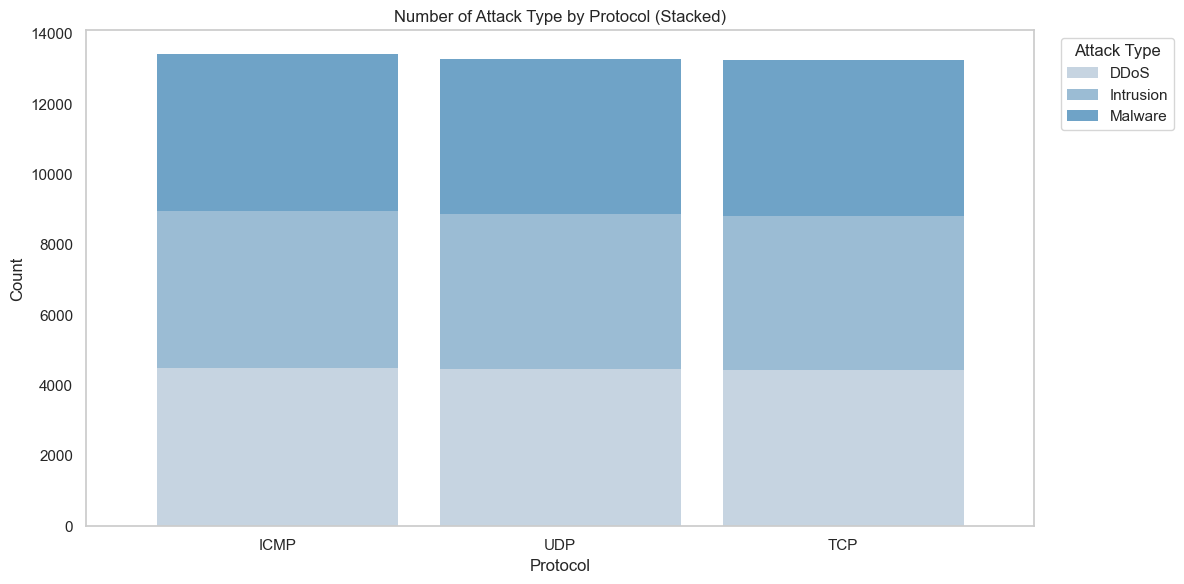

In [46]:
# Number of Attack Type by Protocol (stacked bar)
if col_protocol is None or col_attack_type is None:
    raise KeyError('Could not auto-detect Protocol and/or Attack Type columns.')

attack_by_protocol = (
    df.assign(
        protocol=df[col_protocol].astype('string').fillna('Unknown'),
        attack_type=df[col_attack_type].astype('string').fillna('Unknown'),
    )
      .groupby(['protocol', 'attack_type'], dropna=False)
      .size()
      .reset_index(name='count')
)

attack_by_protocol_pivot = (
    attack_by_protocol.pivot(index='protocol', columns='attack_type', values='count')
      .fillna(0)
    )

# Order protocols by total count (desc)
attack_by_protocol_pivot = attack_by_protocol_pivot.loc[
    attack_by_protocol_pivot.sum(axis=1).sort_values(ascending=False).index
]

attack_types = attack_by_protocol_pivot.columns.tolist()
colors = [color_palette[i % len(color_palette)] for i in range(len(attack_types))]

fig, ax = plt.subplots(figsize=(12, 6))
attack_by_protocol_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Number of Attack Type by Protocol (Stacked)')
ax.set_xlabel('Protocol')
ax.set_ylabel('Count')

ax.grid(False)
ax.tick_params(axis='x', labelrotation=0)
ax.legend(title='Attack Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()

### Number of Device/OS Types by Log Source

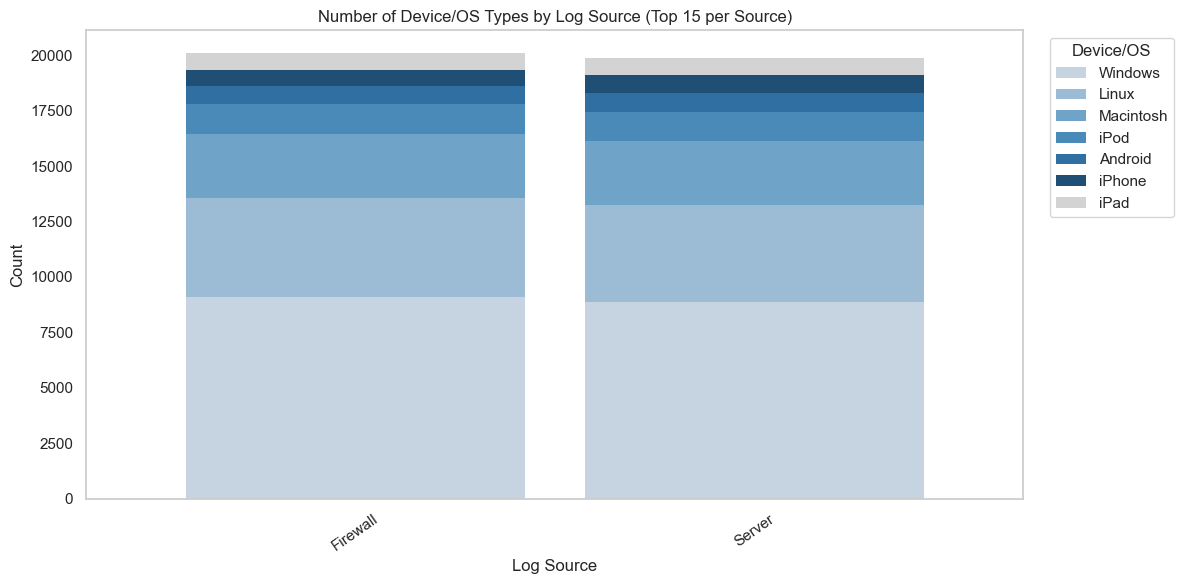

In [47]:
if col_log_source is None:
    raise KeyError('Could not auto-detect Log Source column.')

device_os_col = 'Device/OS' if 'Device/OS' in df.columns else None
if device_os_col is None and col_device is None and col_os is None:
    raise KeyError('Could not auto-detect Device/OS column or (Device and/or OS columns).')

if device_os_col is not None:
    device_os_series = df[device_os_col].astype('string').fillna('Unknown')
else:
    device_os_series = (
        (df[col_device].astype('string').fillna('Unknown') if col_device else 'Unknown')
        + ' | ' +
        (df[col_os].astype('string').fillna('Unknown') if col_os else 'Unknown')
    )

device_os_by_log_source = (
    pd.DataFrame({
        'log_source': df[col_log_source].astype('string').fillna('Unknown'),
        'device_os': device_os_series.astype('string').fillna('Unknown'),
    })
      .groupby(['log_source', 'device_os'], dropna=False)
      .size()
      .reset_index(name='count')
)

# Keep top 15 device/os combos per log source for readability
top_by_source = (
    device_os_by_log_source.sort_values(['log_source', 'count'], ascending=[True, False])
      .groupby('log_source')
      .head(15)
)

# Stacked bar chart: each log source is one bar, segmented by device/os
top_by_source_pivot = (
    top_by_source.pivot_table(
        index='log_source',
        columns='device_os',
        values='count',
        aggfunc='sum',
        fill_value=0,
    )
    .sort_index()
 )

# Sort stack order so the largest segment is at the bottom
device_os_order = top_by_source_pivot.sum(axis=0).sort_values(ascending=False).index
top_by_source_pivot = top_by_source_pivot[device_os_order]

fig, ax = plt.subplots(figsize=(12, 6))
top_by_source_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=sns.color_palette(color_palette, n_colors=top_by_source_pivot.shape[1]) if color_palette else None,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Number of Device/OS Types by Log Source (Top 15 per Source)')
ax.set_xlabel('Log Source')
ax.set_ylabel('Count')
ax.grid(False)
ax.tick_params(axis='x', labelrotation=35)
ax.legend(title='Device/OS', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Action Taken by IDS/IPS Alerts

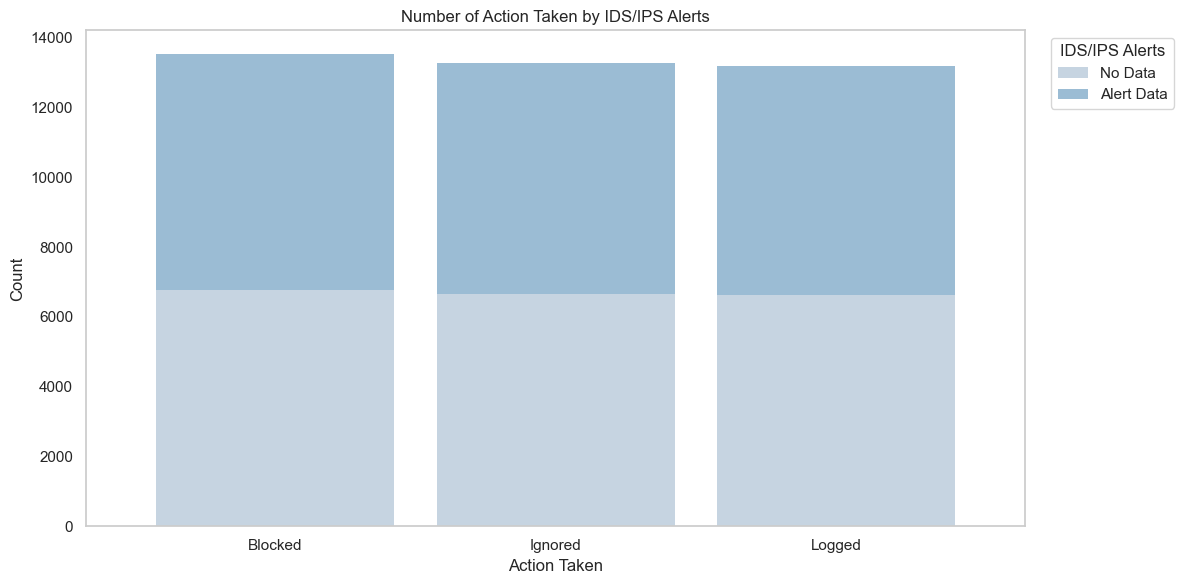

In [48]:
if col_action_taken is None or col_ids_ips_alerts is None:
    raise KeyError('Could not auto-detect Action Taken and/or IDS/IPS Alerts columns.')

action_by_ids = (
    df.assign(
        action=df[col_action_taken].astype('string').fillna('No Data').replace('Unknown', 'No Data'),
        ids_ips=df[col_ids_ips_alerts].astype('string').fillna('No Data').replace('Unknown', 'No Data'),
    )
      .groupby(['action', 'ids_ips'], dropna=False)
      .size()
      .reset_index(name='count')
)

# Stacked bar chart: x-axis = Action Taken; stacks = IDS/IPS Alerts
action_by_ids_pivot = (
    action_by_ids.pivot(index='action', columns='ids_ips', values='count')
      .fillna(0)
 )

# Order actions by total count (desc) and stacks by overall size (desc, largest on bottom)
action_order = action_by_ids_pivot.sum(axis=1).sort_values(ascending=False).index
ids_ips_order = action_by_ids_pivot.sum(axis=0).sort_values(ascending=False).index
action_by_ids_pivot = action_by_ids_pivot.loc[action_order, ids_ips_order]

colors = [color_palette[i % len(color_palette)] for i in range(len(action_by_ids_pivot.columns))]

fig, ax = plt.subplots(figsize=(12, 6))
action_by_ids_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Number of Action Taken by IDS/IPS Alerts')
ax.set_xlabel('Action Taken')
ax.set_ylabel('Count')
ax.grid(False)
ax.tick_params(axis='x', labelrotation=0)
ax.legend(title='IDS/IPS Alerts', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Action Taken by Alerts/Warnings

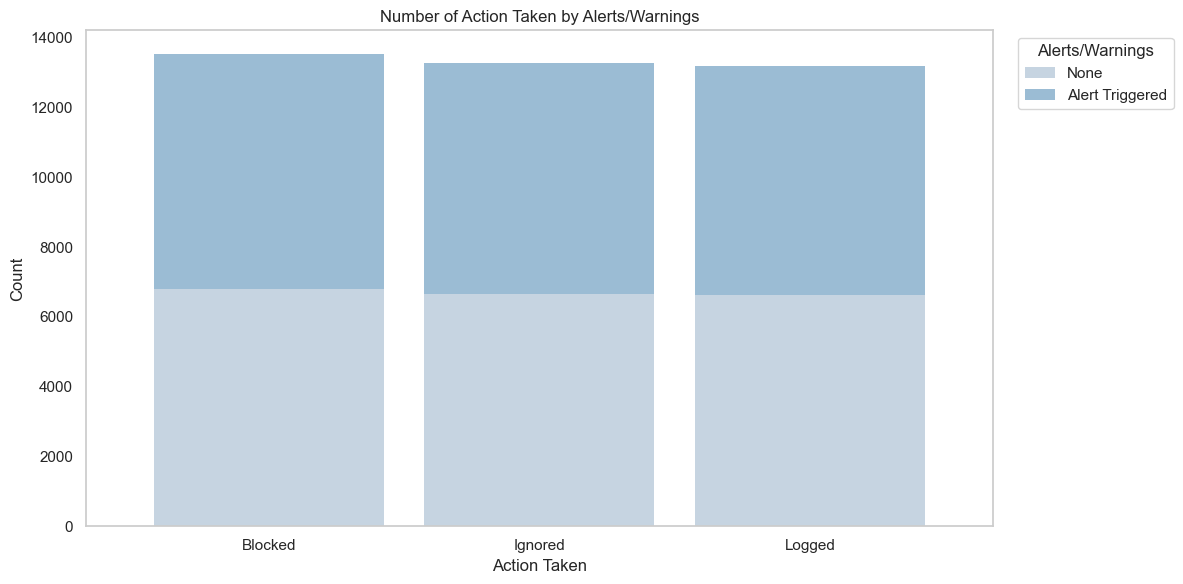

In [49]:
if col_action_taken is None or col_alerts_warnings is None:
    raise KeyError('Could not auto-detect Action Taken and/or Alerts/Warnings columns.')

action_by_alerts = (
    df.assign(
        action=df[col_action_taken].astype('string').fillna('None').replace('Unknown', 'None'),
        alerts=df[col_alerts_warnings].astype('string').fillna('None').replace('Unknown', 'None'),
    )
      .groupby(['action', 'alerts'], dropna=False)
      .size()
      .reset_index(name='count')
)

# Stacked bar chart: x-axis = Action Taken; stacks = Alerts/Warnings
action_by_alerts_pivot = (
    action_by_alerts.pivot(index='action', columns='alerts', values='count')
      .fillna(0)
 )

# Order actions by total count (desc) and stacks by overall size (desc, largest on bottom)
action_order = action_by_alerts_pivot.sum(axis=1).sort_values(ascending=False).index
alerts_order = action_by_alerts_pivot.sum(axis=0).sort_values(ascending=False).index
action_by_alerts_pivot = action_by_alerts_pivot.loc[action_order, alerts_order]

colors = [color_palette[i % len(color_palette)] for i in range(len(action_by_alerts_pivot.columns))]

fig, ax = plt.subplots(figsize=(12, 6))
action_by_alerts_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Number of Action Taken by Alerts/Warnings')
ax.set_xlabel('Action Taken')
ax.set_ylabel('Count')
ax.grid(False)
ax.tick_params(axis='x', labelrotation=0)
ax.legend(title='Alerts/Warnings', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Attack Types by Malware Indicators

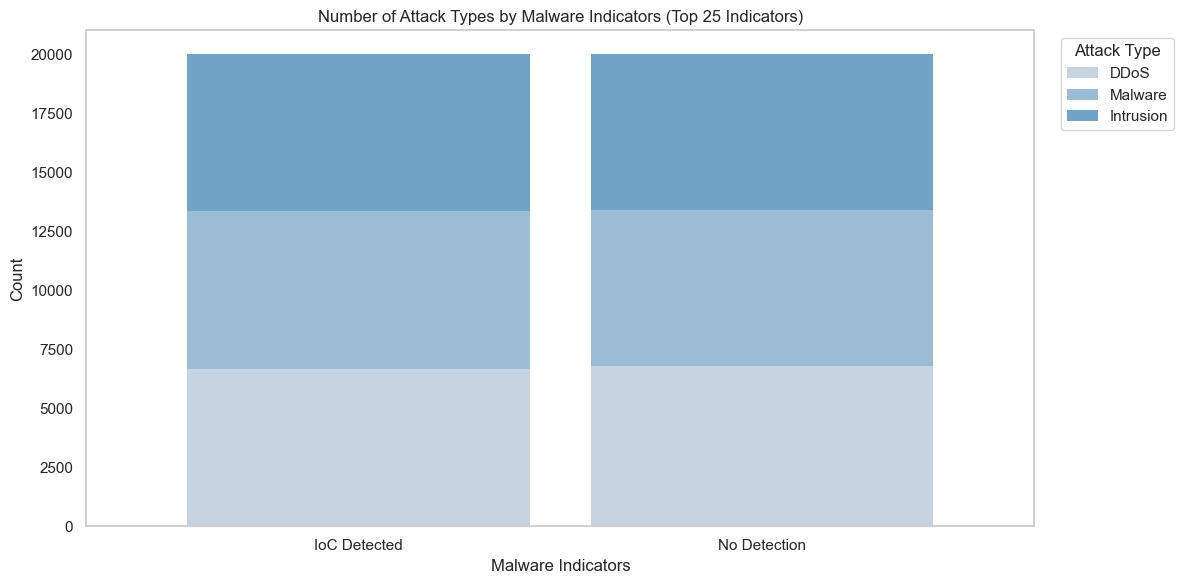

In [50]:
if col_malware_indicators is None or col_attack_type is None:
    raise KeyError('Could not auto-detect Malware Indicators and/or Attack Type columns.')

attack_by_malware = (
    df.assign(
        malware=(
            df[col_malware_indicators]
            .astype('string')
            .fillna('No Detection')
            .replace('Unknown', 'No Detection')
        ),
        attack_type=df[col_attack_type].astype('string').fillna('Unknown'),
    )
      .groupby(['malware', 'attack_type'], dropna=False)
      .size()
      .reset_index(name='count')
)

# For readability, keep top 25 malware indicator values
top_malware = (
    attack_by_malware.groupby('malware', dropna=False)['count'].sum().sort_values(ascending=False).head(25).index
)
attack_by_malware_top = attack_by_malware[attack_by_malware['malware'].isin(top_malware)].copy()

# Stacked bar chart: x-axis = Malware Indicators; stacks = Attack Type
attack_by_malware_pivot = (
    attack_by_malware_top.pivot(index='malware', columns='attack_type', values='count')
      .fillna(0)
 )

# Order malware indicators by total count (desc) and stacks by overall size (desc, largest on bottom)
malware_order = attack_by_malware_pivot.sum(axis=1).sort_values(ascending=False).index
attack_type_order = attack_by_malware_pivot.sum(axis=0).sort_values(ascending=False).index
attack_by_malware_pivot = attack_by_malware_pivot.loc[malware_order, attack_type_order]

colors = [color_palette[i % len(color_palette)] for i in range(len(attack_by_malware_pivot.columns))]

fig, ax = plt.subplots(figsize=(12, 6))
attack_by_malware_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=colors,
    width=0.85,
    edgecolor='none',
)
ax.set_title('Number of Attack Types by Malware Indicators (Top 25 Indicators)')
ax.set_xlabel('Malware Indicators')
ax.set_ylabel('Count')
ax.grid(False)
ax.tick_params(axis='x', labelrotation=0)
ax.legend(title='Attack Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Number of Attack Types by Geo-Location

C:\Users\dave\AppData\Local\Temp\ipykernel_5744\2394868283.py:21: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  ax = sns.barplot(data=attack_by_geo_top, x='geo', y='count', hue='attack_type', palette=color_palette)


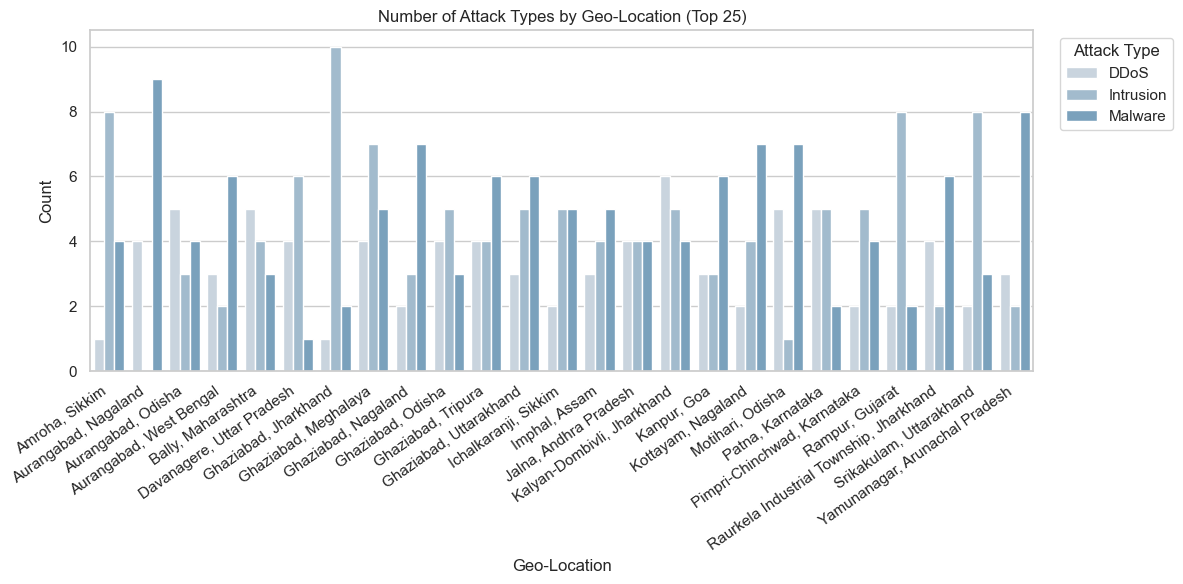

In [51]:
if col_geo is None or col_attack_type is None:
    raise KeyError('Could not auto-detect Geo-location and/or Attack Type columns.')

attack_by_geo = (
    df.assign(
        geo=df[col_geo].astype('string').fillna('Unknown'),
        attack_type=df[col_attack_type].astype('string').fillna('Unknown'),
    )
      .groupby(['geo', 'attack_type'], dropna=False)
      .size()
      .reset_index(name='count')
)

# For readability, keep top 25 geos
top_geo = (
    attack_by_geo.groupby('geo', dropna=False)['count'].sum().sort_values(ascending=False).head(25).index
)
attack_by_geo_top = attack_by_geo[attack_by_geo['geo'].isin(top_geo)].copy()

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=attack_by_geo_top, x='geo', y='count', hue='attack_type', palette=color_palette)
ax.set_title('Number of Attack Types by Geo-Location (Top 25)')
ax.set_xlabel('Geo-Location')
ax.set_ylabel('Count')
plt.xticks(rotation=35, ha='right')
plt.legend(title='Attack Type', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()